# Financial Planning

## Setting up environment

In [62]:
import os
import requests
import json
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import numpy as np

%matplotlib inline

## Collect the crypto data to work

#### Current crypto assets on hand

In [63]:
# My crypto holdings
my_btc = 1.2
my_eth = 5.3

#### URLs of current crypto prices to date

In [64]:
# Getting crypto data from APIs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=json"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=json"

#### Gather the prices in the URL data for BTC and ETH

In [65]:
# Retrieving price data with request command
btc_response = requests.get(btc_url)
eth_response = requests.get(eth_url)

#print(btc_response)

In [66]:
# Converting the response to text for better reading
btc_data = btc_response.text
eth_data = eth_response.text

#print(btc_data)
#print(eth_data)

In [67]:
# Parsing the data in order to use it in my code
btc_parsed = json.loads(btc_data)
eth_parsed = json.loads(eth_data)

#print(json.dumps(btc_parsed, indent=4)) ## Called "pretty read"

In [68]:
# Retrival of the current price for each crypto
btc_price = btc_parsed['data']['1']['quotes']['USD']['price']
eth_price = eth_parsed['data']['1027']['quotes']['USD']['price']

#print(btc_price)

#### My assets' value

In [69]:
my_btc_value = round(my_btc*btc_price, 2)
my_eth_value = round(my_eth*eth_price, 2)

#print(my_eth_value)

In [70]:
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $41542.80
The current value of your 5.3 ETH is $12546.90


#### Investment data from Alpaca API for SPY (stocks) and AGG (bonds)

In [71]:
# Assinging variables to my investment data
investment_portfolio = ['SPY','AGG']

shares = {
    'Shares Data': [50,200]
}

df = pd.DataFrame(shares, index=investment_portfolio)
#df.head()

## Collecting investment data

In [72]:
# Checking if the load_dotenv command is True or False
load_dotenv()

True

In [73]:
# Setting up my API keys to request the data I need
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

#type(alpaca_api_key)
#type(alpaca_secret_key)

### Alpaca API object

In [74]:
# API object to be used for data calling
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [75]:
# Setting of the time and the format for my data
today = pd.Timestamp("2021-07-6", tz="America/New_York").isoformat()

In [76]:
# Setting the timeframe I want my data to show
timeframe = "1D"

In [77]:
# Defining my data frame to get the investment data called
df = alpaca.get_barset(
    investment_portfolio,
    timeframe,
    start = today,
    end = today
).df

#type(df)
#print(df)
#df.dtypes

In [78]:
# Making my index of time readable for me
date = df.index
date = [x.date().isoformat() for x in date]
dt = np.array(date)

df['time'] = date
df['time'] = pd.to_datetime(df['time'], 
                                           infer_datetime_format=True)
df.set_index('time', inplace=True)

#df

#### Cleaning the data to retrieve only closing price

In [79]:
# Create and empty DataFrame for closing prices
df_closing_prices = pd.DataFrame()

# Fetch the closing prices for all the tickers
for ticker in investment_portfolio:
    df_closing_prices[ticker] = df[ticker]["close"]

# Drop the time component of the date
df_closing_prices.index = df_closing_prices.index.date

# Display sample data
#df_closing_prices.head()

#### Printing AGG and SPY prices

In [80]:
# Creating my variables to show only close prices for my investment
spy_close = df_closing_prices['SPY'].values[0]
agg_close = df_closing_prices['AGG'].values[0]

print(f"Current AGG closing price: ${round(agg_close,2)}")
print(f"Current SPY closing price: ${round(spy_close,2)}")

Current AGG closing price: $115.75
Current SPY closing price: $432.9


#### Investment Portfolio Value

In [81]:
# Setting up my portfolio with the actual values I am working with
## Calculating my portfolio value
my_spy = 50
my_agg = 200
my_spy_value = (my_spy*spy_close)
my_agg_value = (my_agg*agg_close)

print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $21645.00
The current value of your 200 AGG shares is $23150.00


## Savings Health Analysis

In [82]:
# Setting variables for my savings analysis
## Calculating total crypto holdings and securities holdings
my_crypto = my_btc_value+my_eth_value 
my_shares = my_spy_value+my_agg_value
monthly_income = 1200

### Setting the dataframe to show the calculated data on a table
df_savings = pd.DataFrame(index=range(2),columns=['Amount'])
df_savings = pd.DataFrame({
    'Amount':[my_crypto,my_shares]
})
df_savings.rename(index={0:'Crypto',1:'Shares'},inplace=True)

df_savings

,Amount
Crypto,54089.7
Shares,44795.0


##### Plotting savings in Pie Chart

,Amount
Crypto,54089.7
Shares,44795.0


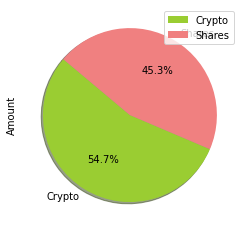

In [83]:
# Variables for my pie chart
labels = 'Crypto','Shares'
colors = ['yellowgreen', 'lightcoral']
explode = (0, 0)

## Plotting my data in pie chart format
df_savings.plot.pie(labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, subplots=True, startangle=140)

df_savings

##### Setting emergency fund

In [84]:
emergency_fund = monthly_income*3
savings = my_crypto+my_shares-emergency_fund

##### Evaluating Savings' Health

In [85]:
savings_health = [savings, emergency_fund]

# Loop used to check if savings show enough emergency fund inside of them
for savings in savings_health:
    if savings>emergency_fund:
        print('Congratulations! You have enough money in your emergency fund.')
    elif savings<emergency_fund:
        print('It is time to focus on savings to create a healthy financial account.')

Congratulations! You have enough money in your emergency fund.


## Retirement Planning

### Monte Carlo Simulation to vizualize portfolio planning projection

In [86]:
# Setting my dates for the Monte Carlo Simulation
start_date = pd.Timestamp('2019-07-07', tz='America/New_York').isoformat()
#end_date = pd.Timestamp('2021-07-06', tz='America/New_York').isoformat()

timeframe='1D'

## Creating the dataframe to view my stock data from the API
df_stock_data = alpaca.get_barset(
    investment_portfolio,
    timeframe,
    start = start_date,
    limit=1000
).df

### Checking dataframe
df_stock_data.tail()

AGG                                        SPY  \
                             open     high     low    close   volume    open   
time                                                                           
2021-06-30 00:00:00-04:00  115.36  115.450  115.30  115.350  5984381  427.20   
2021-07-01 00:00:00-04:00  115.15  115.190  115.01  115.115  4439326  428.83   
2021-07-02 00:00:00-04:00  115.23  115.370  115.17  115.370  4219494  431.67   
2021-07-06 00:00:00-04:00  115.51  115.830  115.51  115.750  7213127  433.78   
2021-07-07 00:00:00-04:00  115.83  116.015  115.75  115.950  4455288  433.66   

                                                               
                             high       low   close    volume  
time                                                           
2021-06-30 00:00:00-04:00  428.78  427.1800  428.08  46776402  
2021-07-01 00:00:00-04:00  430.60  428.8000  430.47  44147835  
2021-07-02 00:00:00-04:00  434.10  430.5218  433.75  46557070  
2021-07-06 00:00:00-04:00  434.01  430.0100  432.90  60410491  
2021-07-07 00:00:00-04:00  434.76  431.5100  434.43  55609308

In [87]:
# Setting variable to read 500 simulatons
num_sims = 500

## Creating the object to show simulation using the MCForecastTools
MC_Portfolio = MCSimulation(
    portfolio_data = df_stock_data,
    weights=[0.60,0.40],
    num_simulation = num_sims,
    num_trading_days = 252*30
)

In [88]:
# Activating simulation
MC_Portfolio.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000865,0.995899,0.986772,1.005518,1.000576,1.001088,0.988382,0.989468,1.003136,0.992728,...,1.005632,1.000867,1.007575,1.004680,1.011423,1.004297,1.001686,1.007072,0.988208,0.989846
2,1.004033,1.006451,0.989282,1.008609,0.998412,1.001035,0.993048,0.988611,1.005892,0.998781,...,1.003661,1.013173,1.011286,1.009735,1.013591,0.999964,1.004048,1.007326,0.981213,0.986873
3,1.012393,1.011325,0.979885,1.000848,1.003043,1.004691,0.994950,0.988256,0.994964,1.002414,...,0.998646,1.007240,1.002357,1.000084,1.010808,1.007735,1.001559,1.000882,0.982336,0.987735
4,1.008208,1.017599,0.970237,1.003586,0.993829,0.991974,0.988534,0.984851,1.003492,0.997163,...,1.000543,1.012239,1.004993,0.992693,1.020216,1.018163,1.014496,1.007773,0.975319,1.000606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,15.451515,17.182893,24.145003,32.363992,26.561081,7.140987,11.963534,46.486104,22.109388,7.364546,...,13.570699,24.619391,7.210455,25.685522,26.292222,17.610447,7.597474,21.028651,10.214513,14.752306
7557,15.339531,17.074992,24.101459,32.521122,26.631780,7.051087,12.159213,46.523464,22.020723,7.301525,...,13.452429,24.730747,7.245213,25.701243,26.415385,17.498079,7.576357,21.017649,10.224890,14.701469
7558,15.349683,17.040772,23.934036,32.578674,26.953029,7.052697,12.166377,46.235224,22.028657,7.218104,...,13.427021,24.516102,7.273009,25.560448,26.496327,17.579073,7.586046,21.150866,10.158995,14.805770
7559,15.238591,17.111118,23.917470,32.767687,27.139405,7.036437,12.212148,45.662957,21.938900,7.189939,...,13.389969,24.436962,7.287860,25.318077,26.396587,17.459152,7.537003,21.525493,10.232866,14.844255


In [89]:
#simulated_returns_data = {
 #   "mean": list(MC_Portfolio.simulated_return.mean(axis=1)),
  #  "median": list(MC_Portfolio.simulated_return.median(axis=1)),
   # "min": list(MC_Portfolio.simulated_return.min(axis=1)),
    #"max": list(MC_Portfolio.simulated_return.max(axis=1))
#}

#df_simulated_returns = pd.DataFrame(simulated_returns_data)

#df_simulated_returns.plot(title="Simulated Daily Returns Behavior of Portfolio Over the Next Year")

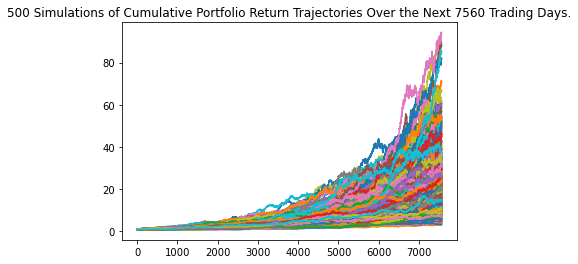

In [95]:
# Plotting simulation to view dataset in graph
simulation = MC_Portfolio.plot_simulation()

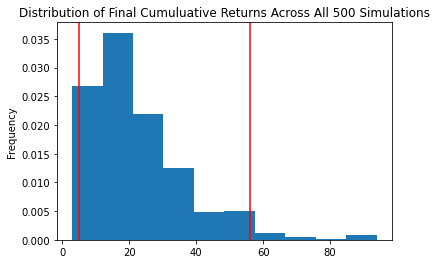

In [91]:
# Showing the distribution 
ditribution = MC_Portfolio.plot_distribution()

## Retirement Analysis

In [92]:
# Fetch the summary statistics from the Monte Carlo simulation results.
summary = MC_Portfolio.summarize_cumulative_return()
summary

count           500.000000
mean             22.302102
std              14.503541
min               2.927109
25%              12.181891
50%              18.758381
75%              29.122662
max              93.841355
95% CI Lower      5.083861
95% CI Upper     55.923116
Name: 7560, dtype: float64

In [93]:
# Given an initial investment of $20,000, 
#calculate the expected portfolio return in dollars at the 95% lower and upper confidence intervals.
initial_investment = 20000
low_confidence = round(summary[8]*initial_investment,2)
high_confidence = round(summary[9]*initial_investment,2)


print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${low_confidence} and ${high_confidence}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $101677.21 and $1118462.33


In [94]:
# Given an initial investment of $20,000, 
#calculate the expected portfolio return in dollars at the 95% lower and upper confidence intervals.
initial_investment = 30000
low_confidence = round(summary[8]*initial_investment,2)
high_confidence = round(summary[9]*initial_investment,2)


print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${low_confidence} and ${high_confidence}")

There is a 95% chance that an initial investment of $30000 in the portfolio over the next 30 years will end within in the range of $152515.82 and $1677693.49
